In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data', name='mpsa')
print(f'training N: {len(data_df)}')
data_df.head()

training N: 16446


,x,y
0,TAAGCTTTA,-3.455265
1,GCAGCCTAT,-3.135494
2,GTGGTAAGG,2.291043
3,TGGGCGCAG,-3.147840
4,GGTGCGGGC,0.547527


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(x=data_df['x'],
                     y=data_df['y'],
                     alphabet='dna',
                     gpmap_type='pairwise',
                     regression_type='GE',
                     ge_noise_model_type='Cauchy',
                     ge_heteroskedasticity_order=2)

# Fit model to data
history = model.fit(learning_rate=.001,
                    epochs=1000,
                    early_stopping=True,
                    early_stopping_patience=10)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    16446 rows  and      612 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      612

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  4.013e+02  1.332e+05   1.0e+00  8.3e-01
     1 -1.01829e-01  1.550e+02  9.273e+03   3.9e-01  1.7e-01  3.6e+02  1.0e+00
     2 -8.98116e-02  1.384e+02  4.159e+03   3.4e-01  7.8e-02  3.8e+02  2.8e+00
     3 -8.50724e-02  1.332e+02  2.989e+03   3.3e-01  5.5e-02  4.0e+02  3.6e+00
     4 -8.20095e-02  1.237e+02  2.300e+03   3.1e-01  4.4e-02  4.2e+02  6.8e+00
     5 -8.11647e-02  1.146e+02  1.274e+03   2.9e-01  2.5e-02  4.4e+02  5.2e+00
     6 -8.34580e-02  1.128e+02  7.444e+02   2.8e-01  1.4e-02  4.6e+02  4.4e+00
     7 -8.44482e-02  1.121e+02  6.116e+02   2.8e-01  1.2e-02  4.6e+02  7.3e+00
     8 -8.20611e-02  1.110e+02  3.037e+02   2.8e-01  5.7e-03  4.8e+02  6.8

Epoch 62/1000
264/264 [==============================] - 0s 2ms/step - loss: 51.1486 - val_loss: 50.1012
Epoch 63/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.1575 - val_loss: 50.1457
Epoch 64/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.1277 - val_loss: 50.3457
Epoch 65/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.1032 - val_loss: 49.8999
Epoch 66/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.0641 - val_loss: 49.7913
Epoch 67/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.0884 - val_loss: 49.9389
Epoch 68/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.0145 - val_loss: 50.3046
Epoch 69/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.0508 - val_loss: 49.8425
Epoch 70/1000
264/264 [==============================] - 0s 1ms/step - loss: 51.0396 - val_loss: 49.7127
Epoch 71/1000
264/264 [==============================] 

In [4]:
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [5]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [6]:
# Load test data
test_df = mavenn.load_example(which='test_data',name='mpsa')
N_test = len(test_df)
print(f'test data N: {N_test:,}')

# Subsample indices for easy plotting
ix = np.random.rand(N_test) < 1

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

test data N: 5,483


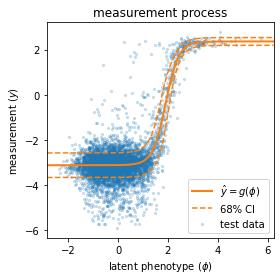

In [7]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

Automatically determined gpmap_type=pairwise.


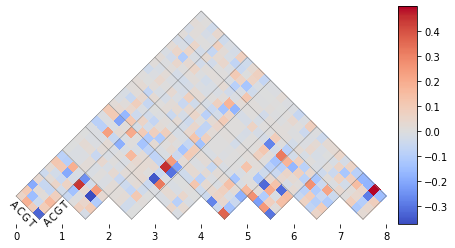

In [8]:
# Plot pairwise parameters
theta_pair_df = model.get_gpmap_parameters(which='pairwise')
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(theta_pair_df, ax=ax);